In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvista as pv
import torch
import seaborn as sns
from os import listdir
from os.path import isfile, join
import multiprocessing
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
# Load wss files from the data directory
mypath = '../../data/MLgSA/wss/'
onlyfiles = np.asarray([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles.sort()
print(len(onlyfiles))
short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])
#short_list.sort()
#short_list

108


In [8]:
# Load the stenosis degree file
df = pd.read_csv("../../data/MLgSA/stenosis_metadata.csv", sep=';')

In [9]:
# Matching the stenosis degree to the datasets
# missing datasets : index = [68, 87, 106]
df.iloc[[68, 87, 106]]

,ID,Stenosis Degree,Min Diameter Position,Min Diameter Normal,Ref Diameter Position,Ref Diameter Normal,Unnamed: 6
68,patient_w_030_right,27.402373,"[-29.677610397338867, -26.901166915893555, -49...","[-0.47144395112991333, -0.5586462616920471, 0....","[-21.575729370117188, -25.14781379699707, -40....","[0.6858331561088562, -0.21918608248233795, 0.6...",NaN
87,patient_w_040_right,30.443229,"[24.264554977416992, -7.138415336608887, -58.6...","[0.5276118516921997, -0.7966058254241943, 0.29...","[28.314176559448242, -13.79305648803711, -52.7...","[-0.3992733657360077, 0.25153839588165283, 0.8...",NaN
106,patient_w_051_left,6.707421,"[-31.28226089477539, 24.9633846282959, -56.382...","[0.17472846806049347, 0.11324866116046906, 0.9...","[-30.387218475341797, 26.080673217773438, -49....","[0.17472846806049347, 0.11324866116046906, 0.9...",NaN


In [10]:
# Drop missing targets
df = df.drop(index=[68, 87, 106])
degree_list = df['ID'].values
#degree_list

In [11]:
# Check to see if the order of files is a match
i = 0
for t, (a,b) in enumerate(zip(degree_list, short_list)):
    if a != b:
        i = t
        print(i)
        print(degree_list[i], short_list[i])
        print(degree_list[i] in short_list)
        break

In [5]:
# Read the corresponding mesh files
meshes = []

for f in onlyfiles:
    reader = pv.get_reader(mypath + f)
    meshes.append(reader.read())

In [33]:
def get_data(mesh_name):
    columns = ['longitudinal_WSS_@_t=1.1', 'non-directional_WSS_@_t=1.1', 'longitudinal_WSS_@_t=1.55', 'non-directional_WSS_@_t=1.55']
    node_array = mesh_name.points
    cell_array = mesh_name.cells.reshape(-1, 4)[:, 1:]
    n = node_array.shape[0]
    adjacency = np.zeros((n, n), dtype=int)
    for c in cell_array:
        adjacency[c[0], c[1]] = 1
        adjacency[c[1], c[0]] = 1
        adjacency[c[1], c[2]] = 1
        adjacency[c[2], c[1]] = 1
        adjacency[c[2], c[0]] = 1
        adjacency[c[0], c[2]] = 1

    features = np.asarray([mesh_name.point_data[columns[0]], mesh_name.point_data[columns[1]], mesh_name.point_data[columns[2]], mesh_name.point_data[columns[3]]]).T

    return torch.tensor(np.maximum(adjacency, adjacency.T)).nonzero().t(), n, features

In [34]:
edjl = []
numl = []
nf = []

p = multiprocessing.Pool()

for j, m in enumerate(meshes):
    edj, num, fe = get_data(m)
    edjl.append(edj)
    numl.append(num)
    nf.append(fe)
    print(j)

p.close()
p.join()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


KeyboardInterrupt: 

In [ ]:
# Normalize features already

In [42]:
mesh = meshes[0]

In [47]:
edges = mesh.extract_all_edges()

In [53]:
meshd = edges.compute_cell_sizes(length=True)

In [55]:
meshd.get_array('Length').shape

(126266,)

In [60]:
# Transforms the unstructured grid into polydata
meshw = mesh.extract_surface()

In [73]:
# creates faces? Idk! see the git issue by searching for "get point coordinates form triangulation mesh"
faces = meshw.faces.reshape((-1, 4))[:, 1:]

In [75]:
# more idk holy shit what the heck `
arr = meshw.points[faces]

In [77]:
arr.shape

(84036, 4, 3)

In [79]:
# This literally returns the 3d coordinates of the points.

mesh.points.shape

(42225, 3)

In [ ]:
torch.save(edjl, '../export/edge_indices.pt')
torch.save(numl, '../export/nodes.pt')
torch.save(nf, '../export/node_features.pt')

In [ ]:
data_list = [Data(x = a, edge_index=b, y = y) for (a, b, y) in zip(nf, edjl, df['Stenosis Degree'])]

torch.save(data_list, '../export/dataset.pt')

In [13]:
data_list = torch.load('../export/dataset.pt')
del data_list[33]

In [14]:
nf = torch.load('../export/node_features.pt')
edjl = torch.load('../export/edge_indices.pt')
numl = torch.load( '../export/nodes.pt')
del nf[33]
del edjl[33]
del numl[33]

In [15]:
# More checks
for j, n in enumerate(numl):
    if n != data_list[j].num_nodes:
        print(j)
    if data_list[j].is_directed():
        print(j)

In [16]:
# Means and Stds

ys = [pt.y for pt in data_list]

In [17]:
# Target Variability

mean_y = np.mean([pt.y for pt in data_list])
max_y = np.max([pt.y for pt in data_list])
min_y = np.min([pt.y for pt in data_list])
std_y = np.std([pt.y for pt in data_list])

In [ ]:
print(mean_y, max_y, min_y, std_y)

In [ ]:
counts, bins = np.histogram([pt.y for pt in data_list])
plt.hist(ys)
plt.savefig('../export/nonunifhist.pdf', format='pdf')

In [ ]:
sns.histplot(ys)
plt.savefig('../export/nonunifhist.pdf', format='pdf')

In [ ]:
print(counts, '\n', bins)

In [ ]:
plt.hist(ys, bins=[0, 5, 10, 15, 25, 40, 90])

In [9]:
def F(x):
    return sum([y <= x for y in ys])/len(ys)

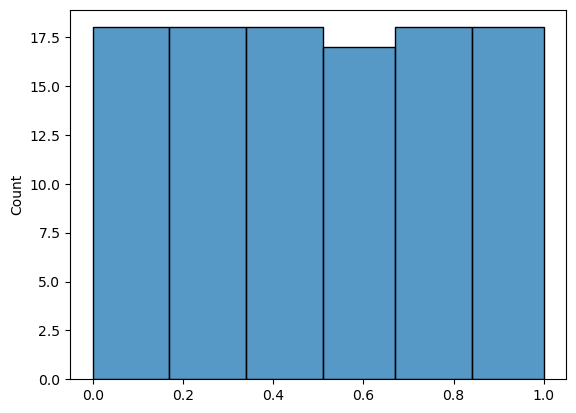

In [10]:
hat_y = [F(y) for y in ys]

sns.histplot(hat_y, bins = [0.0, 0.17, 0.34, 0.51 , 0.67, 0.84, 1.])
plt.savefig('../export/unifhist.pdf', format='pdf')

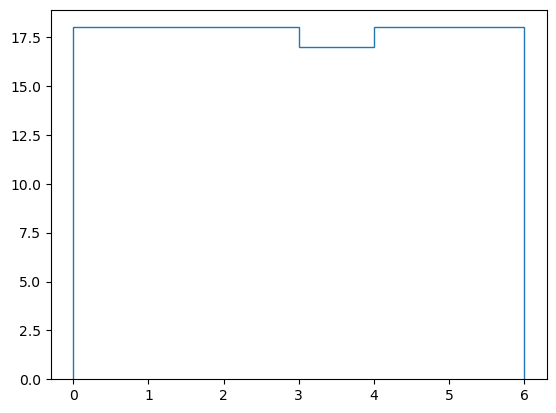

In [12]:
counts, bins =np.histogram(hat_y,bins=[0.0, 0.17, 0.34, 0.51 , 0.67, 0.84, 1.])

plt.stairs(counts)

In [13]:
dy = np.digitize(hat_y, bins, right=True) - 1

In [14]:
print((dy, ys))

(array([4, 5, 2, 0, 3, 4, 5, 1, 4, 4, 1, 3, 4, 5, 5, 0, 1, 1, 2, 3, 4, 0,
       3, 3, 4, 0, 2, 0, 0, 2, 2, 4, 2, 5, 5, 2, 2, 3, 1, 1, 4, 5, 2, 1,
       1, 1, 2, 4, 3, 3, 4, 5, 1, 3, 2, 1, 0, 3, 2, 5, 0, 5, 2, 3, 2, 0,
       4, 3, 5, 5, 0, 0, 1, 1, 4, 4, 1, 4, 4, 5, 4, 5, 3, 0, 0, 2, 1, 2,
       3, 3, 1, 2, 0, 5, 3, 5, 5, 3, 1, 2, 0, 0, 4, 0, 5, 0, 1],
      dtype=int64), [26.126666520373508, 71.55461808841325, 14.989693821100936, 3.440384067120566, 21.13145726892333, 36.81742624699327, 75.67920912829408, 10.03391473333917, 25.105676903367453, 30.584103289543624, 5.548061468416428, 22.193821413445946, 36.48818124997736, 40.43076571427493, 63.51410691643756, 2.171972995840946, 5.024651076526039, 7.078013489518377, 11.867340411825444, 22.065576366226534, 31.659627305267858, 4.093569336460916, 18.472349849726157, 17.76002255504098, 33.358993870589075, 4.5258716407333655, 11.50381182366406, 3.2261573248520152, 2.850462890845114, 11.094062870783072, 10.812626527614096, 38.4997594950185, 

In [15]:
y_classes = np.zeros((len(ys), 6))

In [16]:
for k, c in zip(y_classes, dy):
    k[c] = 1.0

In [17]:
y_classes[81]

array([0., 0., 0., 0., 0., 1.])

In [18]:
means = []
stds = []
mins = []
maxs = []

In [19]:
for t, pt in enumerate(nf):
    means.append(torch.mean(pt, axis =0))
    stds.append(torch.std(pt, axis =0))
    mins.append(torch.amin(pt, axis =0))
    maxs.append(torch.amax(pt, axis =0))

In [20]:
for m in stds:
    if np.isnan(m).any():
        print('yolo')

In [29]:
torch.mean(torch.tensor(means, dtype=torch.float32), axis=1)

ValueError: only one element tensors can be converted to Python scalars

In [18]:

for t, gp in enumerate(data_list):
    s = StandardScaler()
    s.fit(gp.x)
    data_list[t].x = s.transform(gp.x)

In [19]:
# Transform targets to classes

for t in range(len(data_list)):
    data_list[t].y = torch.tensor(y_classes[t], dtype=torch.float32)

In [20]:
for t in range(len(data_list)):
    data_list[t].x = torch.tensor(data_list[t].x, dtype=torch.float32)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_list, y_classes,
                                                    stratify=y_classes,
                                                    test_size=0.25)

In [22]:
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1)

In [23]:
torch.save(train_loader, '../export/train_loader.pt')
torch.save(test_loader, '../export/test_loader.pt')

In [6]:
mesh = meshes[0]

In [7]:
mesh.cell_centers()

PolyData,Information
N Cells,84036
N Points,84036
N Strips,0
X Bounds,"2.610e+01, 6.522e+01"
Y Bounds,"-3.124e+01, -2.818e+00"
Z Bounds,"-1.153e+02, -4.102e+01"
N Arrays,0


In [ ]:
grid = mesh.extract_surface()

In [ ]:
grid.compute_normals(inplace=True, cell_normals=False)

In [ ]:
grid.plot(scalars='Normals-normed')

In [ ]:
grid.point_data.set_scalars(cur, 'curvature')

In [ ]:
grid.save(mypath+onlyfiles[3]+'_with_normals.vtk')

In [ ]:
np.linalg.norm([-0.23306529, -0.8930662 ,  0.3848549 ])

In [ ]:
curv = grid.curvature(curv_type='minimum')

In [ ]:
grid.plot(scalars=curv)

In [ ]:
pl = pv.Plotter()
pl.add_mesh(mesh, scalars='longitudinal_WSS_@_t=1.1')
pl.show()

In [ ]:
grid

In [ ]:
grid.point_data_to_cell_data(1500)

In [62]:
dy = np.digitize(hat_y, bins, right=True) - 1

In [ ]:
print((dy, ys))

In [63]:
y_classes = np.zeros((len(ys), 6))

In [64]:
for k, c in zip(y_classes, dy):
    k[c] = 1.0

In [65]:
y_classes[81]

array([0., 0., 0., 0., 0., 1.])

In [ ]:
means = []
stds = []
mins = []
maxs = []

In [ ]:
for t, pt in enumerate(nf):
    means.append(torch.mean(pt, axis =0))
    stds.append(torch.std(pt, axis =0))
    mins.append(torch.amin(pt, axis =0))
    maxs.append(torch.amax(pt, axis =0))

In [ ]:
for m in stds:
    if np.isnan(m).any():
        print('yolo')

In [ ]:
len(means)

In [77]:

for t, gp in enumerate(data_list):
    s = StandardScaler()
    s.fit(gp.x)
    data_list[t].x = s.transform(gp.x)

In [78]:
# Transform targets to classes

for t in range(len(data_list)):
    data_list[t].y = torch.tensor(y_classes[t], dtype=torch.float32)

In [79]:
for t in range(len(data_list)):
    data_list[t].x = torch.tensor(data_list[t].x, dtype=torch.float32)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(data_list, y_classes,
                                                    stratify=y_classes,
                                                    test_size=0.25)

In [81]:
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1)

In [82]:
torch.save(train_loader, '../export/train_loader.pt')
torch.save(test_loader, '../export/test_loader.pt')

In [ ]:
df

In [8]:
reader = pv.get_reader(mypath + onlyfiles[3])
mesh = reader.read()

In [9]:
mesh.points.shape

(19602, 3)

In [11]:
mesh.point_normals

AttributeError: 'UnstructuredGrid' object has no attribute 'point_normals'

In [13]:
grid = mesh.extract_surface()

In [22]:
grid.compute_normals(inplace=True, cell_normals=False)

PolyData (0x7f9c2b2ee920)
  N Cells:	38974
  N Points:	19602
  N Strips:	0
  X Bounds:	-3.539e+01, -2.374e+01
  Y Bounds:	-1.383e+00, 1.738e+01
  Z Bounds:	-1.010e+02, -3.445e+01
  N Arrays:	9

/home/rohit/anaconda3/envs/ader/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


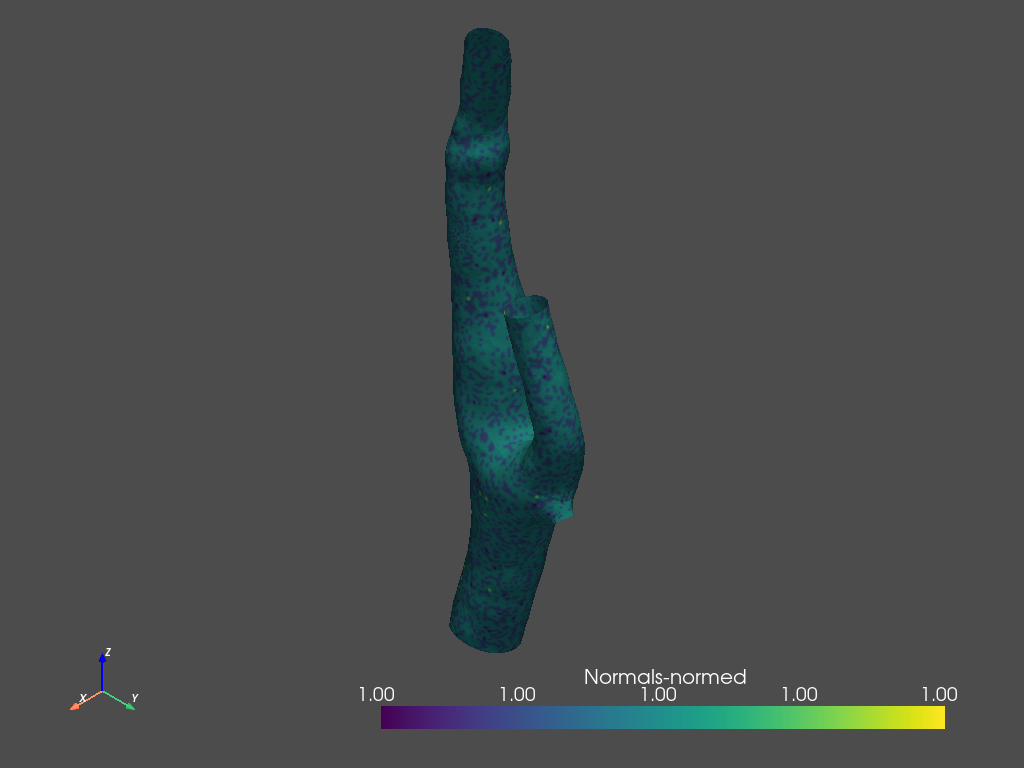

In [24]:
grid.plot(scalars='Normals-normed')

In [42]:
grid.point_data.set_scalars(cur, 'curvature')

In [45]:
grid.save(mypath+onlyfiles[3]+'_with_normals.vtk')

In [36]:
np.linalg.norm([-0.23306529, -0.8930662 ,  0.3848549 ])

0.9999999805196169

In [50]:
curv = grid.curvature(curv_type='minimum')

2023-03-28 16:09:06.513 (5624.807s) [        9BF14740]      vtkCurvatures.cxx:416   WARN| vtkCurvatures (0x55bd36781570): The Gaussian or mean curvature at point 0 have a large computation error... The minimum curvature is likely off.
2023-03-28 16:09:06.513 (5624.807s) [        9BF14740]      vtkCurvatures.cxx:416   WARN| vtkCurvatures (0x55bd36781570): The Gaussian or mean curvature at point 2 have a large computation error... The minimum curvature is likely off.
2023-03-28 16:09:06.513 (5624.807s) [        9BF14740]      vtkCurvatures.cxx:416   WARN| vtkCurvatures (0x55bd36781570): The Gaussian or mean curvature at point 4 have a large computation error... The minimum curvature is likely off.
2023-03-28 16:09:06.513 (5624.807s) [        9BF14740]      vtkCurvatures.cxx:416   WARN| vtkCurvatures (0x55bd36781570): The Gaussian or mean curvature at point 5 have a large computation error... The minimum curvature is likely off.
2023-03-28 16:09:06.513 (5624.807s) [        9BF14740]      

/home/rohit/anaconda3/envs/ader/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


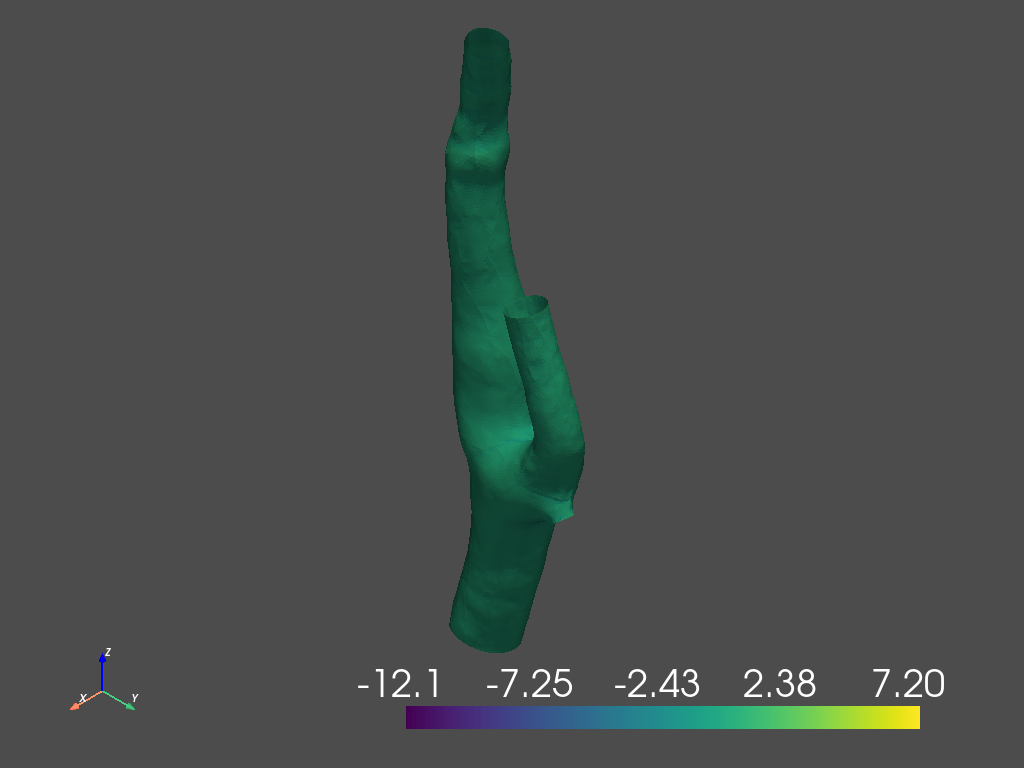

In [51]:
grid.plot(scalars=curv)

/home/rohit/anaconda3/envs/ader/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


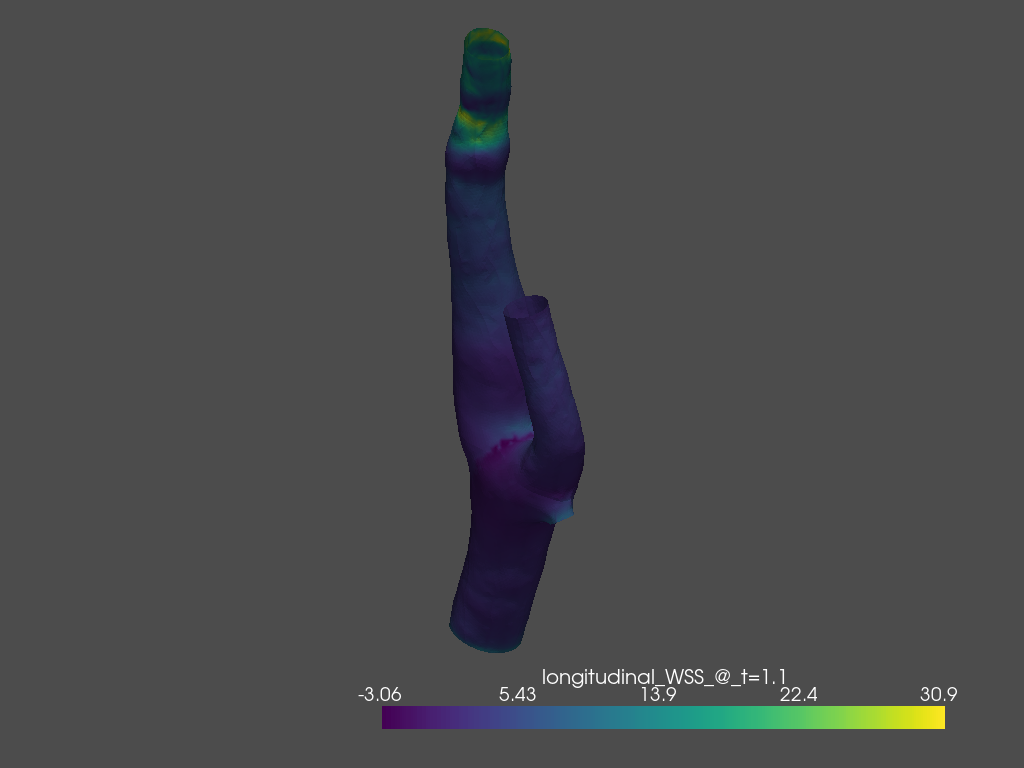

In [25]:
pl = pv.Plotter()
pl.add_mesh(mesh, scalars='longitudinal_WSS_@_t=1.1')
pl.show()

In [53]:
grid

PolyData (0x7f9c2b2ee920)
  N Cells:	38974
  N Points:	19602
  N Strips:	0
  X Bounds:	-3.539e+01, -2.374e+01
  Y Bounds:	-1.383e+00, 1.738e+01
  Z Bounds:	-1.010e+02, -3.445e+01
  N Arrays:	11

In [54]:
grid.point_data_to_cell_data(1500)

PolyData (0x7f9c22682bc0)
  N Cells:	38974
  N Points:	19602
  N Strips:	0
  X Bounds:	-3.539e+01, -2.374e+01
  Y Bounds:	-1.383e+00, 1.738e+01
  Z Bounds:	-1.010e+02, -3.445e+01
  N Arrays:	18

In [205]:
print((dy, ys))

(array([4, 5, 2, 0, 3, 4, 5, 1, 4, 4, 1, 3, 4, 5, 5, 0, 1, 1, 2, 3, 4, 0,
       3, 3, 4, 0, 2, 0, 0, 2, 2, 4, 2, 5, 5, 2, 2, 3, 1, 1, 4, 5, 2, 1,
       1, 1, 2, 4, 3, 3, 4, 5, 1, 3, 2, 1, 0, 3, 2, 5, 0, 5, 2, 3, 2, 0,
       4, 3, 5, 5, 0, 0, 1, 1, 4, 4, 1, 4, 4, 5, 4, 5, 3, 0, 0, 2, 1, 2,
       3, 3, 1, 2, 0, 5, 3, 5, 5, 3, 1, 2, 0, 0, 4, 0, 5, 0, 1],
      dtype=int64), [26.126666520373508, 71.55461808841325, 14.989693821100936, 3.440384067120566, 21.13145726892333, 36.81742624699327, 75.67920912829408, 10.03391473333917, 25.105676903367453, 30.584103289543624, 5.548061468416428, 22.193821413445946, 36.48818124997736, 40.43076571427493, 63.51410691643756, 2.171972995840946, 5.024651076526039, 7.078013489518377, 11.867340411825444, 22.065576366226534, 31.659627305267858, 4.093569336460916, 18.472349849726157, 17.76002255504098, 33.358993870589075, 4.5258716407333655, 11.50381182366406, 3.2261573248520152, 2.850462890845114, 11.094062870783072, 10.812626527614096, 38.4997594950185, 

In [206]:
y_classes = np.zeros((len(ys), 6))

In [207]:
for k, c in zip(y_classes, dy):
    k[c] = 1.0

In [208]:
y_classes[81]

array([0., 0., 0., 0., 0., 1.])

In [141]:
means = []
stds = []
mins = []
maxs = []

In [142]:
for t, pt in enumerate(nf):
    means.append(torch.mean(pt, axis =0))
    stds.append(torch.std(pt, axis =0))
    mins.append(torch.amin(pt, axis =0))
    maxs.append(torch.amax(pt, axis =0))

In [146]:
for m in stds:
    if np.isnan(m).any():
        print('yolo')

In [147]:
len(means)

107

In [155]:

for t, gp in enumerate(data_list):
    s = StandardScaler()
    s.fit(gp.x)
    print(gp.x)
    data_list[t].x = s.transform(gp.x)
    print(t, data_list[t].x)

[[-0.60021586 -0.72791386 -0.59051759 -0.68328535]
 [-0.6157197  -0.74364276 -0.61596402 -0.70890331]
 [-0.62540497 -0.75366467 -0.62548184 -0.71858322]
 ...
 [-0.90276345 -1.0342306  -0.69310765 -0.78668268]
 [-0.88163841 -1.01309291 -0.63184979 -0.72501378]
 [-0.91047794 -1.04226072 -0.70761969 -0.8012693 ]]
0 [[-0.60021586 -0.72791386 -0.59051759 -0.68328535]
 [-0.6157197  -0.74364276 -0.61596402 -0.70890331]
 [-0.62540497 -0.75366467 -0.62548184 -0.71858322]
 ...
 [-0.90276345 -1.0342306  -0.69310765 -0.78668268]
 [-0.88163841 -1.01309291 -0.63184979 -0.72501378]
 [-0.91047794 -1.04226072 -0.70761969 -0.8012693 ]]
[[ 0.69500691  0.59528948  0.52322715  0.42730887]
 [ 0.89796587  0.79056877  0.67872066  0.58186653]
 [ 0.66963398  0.57686128  0.51917275  0.42385596]
 ...
 [ 0.08340089 -0.0425283   0.02852    -0.06757192]
 [ 0.19999584  0.06946833  0.03544232 -0.06810604]
 [ 0.01911682 -0.11190255 -0.08743244 -0.1922421 ]]
1 [[ 0.69500691  0.59528948  0.52322715  0.42730887]
 [ 0.8979

In [228]:
# Transform targets to classes

for t in range(len(data_list)):
    data_list[t].y = torch.tensor(y_classes[t], dtype=torch.float32)

In [229]:
for t in range(len(data_list)):
    data_list[t].x = torch.tensor(data_list[t].x, dtype=torch.float32)

C:\Users\Rohit\AppData\Local\Temp\ipykernel_32688\3771077959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_list[t].x = torch.tensor(data_list[t].x, dtype=torch.float32)


In [225]:
X_train, X_test, y_train, y_test = train_test_split(data_list, y_classes,
                                                    stratify=y_classes,
                                                    test_size=0.25)

In [226]:
train_loader = DataLoader(X_train, batch_size=1)
test_loader = DataLoader(X_test, batch_size=1)

In [227]:
torch.save(train_loader, '../export/train_loader.pt')
torch.save(test_loader, '../export/test_loader.pt')

In [223]:
df

,ID,Stenosis Degree,Min Diameter Position,Min Diameter Normal,Ref Diameter Position,Ref Diameter Normal,Unnamed: 6
0,patient_k_002_left,26.126667,"[39.892398834228516, -13.870604515075684, -66....","[-0.3423857092857361, 0.17876523733139038, 0.9...","[33.187835693359375, -14.544608116149902, -56....","[-0.8399626016616821, -0.34622809290885925, 0....",NaN
1,patient_k_003_left,71.554618,"[26.116363525390625, 21.686115264892578, -45.4...","[0.9549748301506042, 0.24799606204032898, 0.16...","[36.01955795288086, 20.092430114746094, -36.90...","[0.29553425312042236, -0.11527381092309952, 0....",NaN
2,patient_k_003_right,14.989694,"[4.305545806884766, 7.88148307800293, -27.8069...","[-0.5527075529098511, -0.48724740743637085, 0....","[-4.710724353790283, 3.768615245819092, -22.50...","[-0.8568196296691895, -0.35291939973831177, 0....",NaN
3,patient_k_004_left,3.440384,"[-30.61272621154785, 5.345273494720459, -73.70...","[-0.12395122647285461, -0.3688310980796814, 0....","[-31.052173614501953, 4.205606937408447, -69.2...","[-0.06483906507492065, -0.1270258128643036, 0....",NaN
4,patient_k_004_right,21.131457,"[36.20441436767578, 0.3623444736003876, -85.02...","[0.02325478009879589, -0.28461888432502747, 0....","[36.174163818359375, -0.3618420958518982, -79....","[0.11890460550785065, -0.01905759610235691, 0....",NaN
...,...,...,...,...,...,...,...
105,patient_w_050_right,25.241225,"[30.245187759399414, -13.944009780883789, -29....","[-0.29351523518562317, 0.010705090127885342, 0...","[28.84402847290039, -13.325772285461426, -23.3...","[-0.437561959028244, 0.15978144109249115, 0.88...",NaN
107,patient_w_051_right,4.632848,"[26.021587371826172, 22.30548667907715, -48.22...","[0.03491294011473656, 0.2581380605697632, 0.96...","[26.072324752807617, 23.233577728271484, -45.7...","[0.03491294011473656, 0.2581380605697632, 0.96...",NaN
108,patient_w_052_left,72.419130,"[-34.688209533691406, 0.7742701768875122, 41.7...","[-0.1835705041885376, -0.09893859922885895, 0....","[-35.026451110839844, 1.8538169860839844, 53.1...","[0.28493279218673706, 0.31433069705963135, 0.9...",NaN
109,patient_w_053_left,2.757718,"[-33.1710090637207, -7.436668872833252, -49.85...","[0.2024630457162857, 0.33531683683395386, 0.92...","[-32.573421478271484, -6.8624138832092285, -47...","[0.34620749950408936, 0.2718786895275116, 0.89...",NaN


In [222]:
onlyfiles[33]

'data_patient_w_008_right_wss.vtu'

In [3]:
reader = pv.get_reader(mypath + onlyfiles[33])
mesh = reader.read()

In [6]:
mesh.points.shape

(33660, 3)

In [10]:
nf = mesh.get_array('longitudinal_WSS_@_t=1.1')

In [37]:
nw = list( zip(* map( list, np.where(np.isnan(nf) ) ) ) )

pointsn = pv.PolyData(mesh.points[nw].reshape(-1, 3))

In [4]:
pl = pv.Plotter()
pl.add_mesh(mesh, scalars='longitudinal_WSS_@_t=1.1')
pl.add_points(pointsn, render_points_as_spheres=True, point_size=1.)
pl.show()

NameError: name 'mesh' is not defined

In [45]:
mesh.remove_points(nw)

AttributeError: 'UnstructuredGrid' object has no attribute 'remove_points'

In [29]:
mesh.points

pyvista_ndarray([[-37.93020468,  -9.87389993, -41.60447419],
                 [-37.94564958,  -9.86791474, -41.55137475],
                 [-37.97857554,  -9.8345473 , -41.60371369],
                 ...,
                 [-33.57247035, -13.35515718, -48.39478846],
                 [-33.63565021, -13.37436255, -48.47498217],
                 [-33.6030603 , -13.36583697, -48.43542976]])

In [34]:
np.amax(mesh.points, axis=0)

pyvista_ndarray([-11.93719735,  18.44834062, -41.16251321])

In [31]:
mesh.points.shape

(33660, 3)

In [48]:
smesh =mesh.cast_to_explicit_structured_grid()

TypeError: 'BLOCK_I', 'BLOCK_J' and 'BLOCK_K' cell arrays are required

In [49]:
mesh.cell_data.keys()

[]

AttributeError: 'UnstructuredGrid' object has no attribute 'remove_points'

In [55]:
keep_points = np.ones(mesh.points.shape, dtype=bool)
keep_points[nw] = False

In [56]:
new_mesh = pv.UnstructuredGrid(points=mesh.points[keep_points], cells=mesh.cells)

In [58]:
new_mesh.points

pyvista_ndarray([], shape=(0, 3), dtype=float64)